![uc3m](img/uc3m.jpg)

# Algorithms for Unconstrained Optimization

<a href="http://www.est.uc3m.es/nogales" target="_blank">Javier Nogales</a>



We are interested in minimizing $f(x)$ where $x$ is a vector

![s](Algs for Unconstrained Optimization/grad.png)

Algorithms are based on iterations: $x_{k+1}=x_k + \alpha_k p_k$

Ideally, algorithms should satisfy: $f(x_{k+1})<f(x_k)$

## General framework for algorithms

![s](Algs for Unconstrained Optimization/algo.png)

Many versions depending on the choice of the search direction and step length

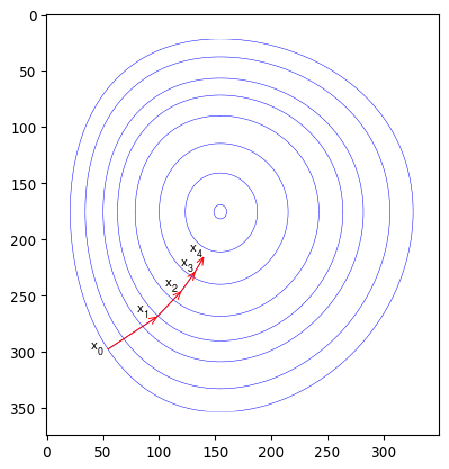

In [5]:
from skimage import io
img = io.imread("grad.png")
io.imshow(img)

### The Gradient Algorithm

Simple idea with $p_k=-\nabla f(x_k)$

We will implement the algorithms with automatic differenciation (for the gradients) using Tensorflow
    
    conda install -c conda-forge tensorflow 


- TensorFlow is an open source software library for numerical computations written in C++ (not confined to NNs)

- Originally developed by researchers in Google to perform distributed computation, deal with large datasets, automatic differentiation, optimization algorithms, etc.

The automatic differenciation of TensorFlow is based on the GradientTape API 

The next function provides the gradient and hessian matrix for any function $f$ at any point $x$

In [6]:
def derivatives(x, f, order = 1):
    
    x = tf.Variable(x)

    with tf.GradientTape() as t1:
        with tf.GradientTape() as t2:
            y = f(x)
            
        g = t2.gradient(y, x) # the gradient vector
    
    if order == 2:
        g = [g, t1.jacobian(g,x)] # the hessian matrix
        
    return g

Now we are ready to implement the Gradient Algorithm

In [7]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
# The gradient algorithm

def gradient(fun, x0, sigma = 0.001, beta = 0.5, verbose = 0, itmax = 100):
    
    f = fun(x0)
    g = derivatives(x0, fun).numpy()
    it = 1; x = x0; 
    
    while (np.linalg.norm(g) > 1.0e-6) & (it < itmax):

        g = derivatives(x, fun).numpy() # the gradient
        p = -g # the search direction; divide by ||g|| to scale better, not mandatory

        alpha = 1 # the step length
        ff = fun(x + alpha * p)
        # backtracking
        it_back = 1
        while (ff > f + sigma * alpha * np.dot(p, g)) & (it_back<20): # Armijo rule // The step length          
            alpha = alpha * beta
            ff = fun(x + alpha * p)
            it_back = it_back+1
        
        # Most important line
        # Movement and updates
        x = x + alpha * p
        f = ff 
        g = derivatives(x, fun).numpy()
        it = it + 1
        
    # Output format
    if it == itmax:
        print('The algorithm does not converge for {:d} iterations'.format(itmax)) 
        
    if verbose > 0 and it < itmax:
        print('The algorithm converges in {:d} iterations'.format(it))
        
    if verbose == 1 or verbose == 2:
        print('The final point is ({:.3}, {:.3})'.format(x[0],x[1]))
            
        if verbose == 2:
            print('The optimal value function is {:.3} \n'.format(ff))
            
    return x, ff, it

### Four examples

![s](img/FourExamples.png)


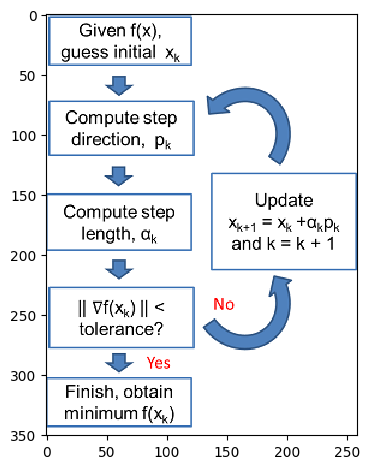

In [8]:
img = io.imread("FourExamples.png")
io.imshow(img)

In [4]:
f1 = lambda x: x[0]**2 + 5 * x[1]**2 + x[0] - 5 * x[1]
f2 = lambda x: x[0]**2 + 5 * x[0] * x[1] + 100 * x[1]**2 - x[0] + 4 * x[1]
f3 = lambda x: np.e**(x[0] + 3 * x[1] - 0.1) + np.e**(x[0] - 3 * x[1] -0.1) + np.e**(-x[0] - 0.1)
f4 = lambda x: (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2  

In [5]:
np.random.seed(2)
x0=np.random.rand(2)*10
x, ff, it = gradient(f1, x0, verbose = 2)

The algorithm converges in 14 iterations
The final point is (-0.5, 0.5)
The optimal value function is -1.5 



In [6]:
np.random.seed(2)
x0=np.random.rand(2)*10
x, ff, it = gradient(f2, x0, verbose = 2)

The algorithm does not converge for 100 iterations
The final point is (1.07, -0.0568)
The optimal value function is -0.136 



This is a difficult function, let's change some hyper-parameters

In [33]:
x, ff, it = gradient(f2, x0, sigma=0.5, beta=0.5, itmax=200, verbose = 2) # Change number of iterations

The algorithm does not converge for 200 iterations
The final point is (0.576, -0.0342)
The optimal value function is -0.363 



Still difficult. Let's try $f_3$

In [31]:
np.random.seed(2)
x0=np.random.rand(2)*10
x, ff, it = gradient(f3, x0, verbose = 2)

/Users/javiernogales/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


The algorithm converges in 46 iterations
The final point is (-0.347, -3.85e-08)
The optimal value function is 2.56 



Let's see the Rosenbrock's function

In [37]:
x0 = np.array([-1.2,1.0]) # difficult initial point
x, ff, it = gradient(f4, x0, verbose = 2)

The algorithm does not converge for 100 iterations
The final point is (0.934, 0.873)
The optimal value function is 0.00434 



Change some hyper-parameters

In [46]:
x, ff, it = gradient(f4, x0, sigma = 0.1, beta = 0.5, itmax=400, verbose = 2)
# Uses only first derivatives
# Cannot see well where it is
# This is why it requires more iterations

The algorithm does not converge for 400 iterations
The final point is (0.867, 0.75)
The optimal value function is 0.0179 



This function requires second-order information to converge better

### The Newton's method

In [47]:
def newton(fun, x0, sigma = 0.001, beta = 0.5, verbose = 0, itmax = 100):
    
    f = fun(x0)
    g = derivatives(x0, fun).numpy()
    it = 1; x = x0; 
    
    # Algorithm is the same for Newton

    while (np.linalg.norm(g) > 1.0e-6) & (it < itmax):
        
        # Call tensorflow to get the values
        g, H = derivatives(x, fun, 2) # the gradient and hessian
        g = g.numpy() 
        H = H.numpy()

        p = - np.dot(np.linalg.inv(H), g) # the search direction

        alpha = 1 # the step length
        ff = fun(x + alpha * p)
        # backtracking
        it_back = 1
        while (ff > f + sigma * alpha * np.dot(p, g)) & (it_back<20): # Armijo rule           
            alpha = alpha * beta
            ff = fun(x + alpha * p)
            it_back = it_back+1
        
        # Movement and updates
        x = x + alpha * p
        f = ff 
        g = derivatives(x, fun).numpy()
        it = it + 1
        
    # Output format
    if it == itmax:
        print('The algorithm does not converge for {:d} iterations'.format(itmax)) 
        
    if verbose > 0 and it < itmax:
        print('The algorithm converges in {:d} iterations'.format(it))
        
    if verbose == 1 or verbose == 2:
        print('The final point is ({:.3}, {:.3})'.format(x[0],x[1]))
            
        if verbose == 2:
            print('The optimal value function is {:.3} \n'.format(ff))
            
    return x, ff, it

Take care: we need to start close to the solution!

In [48]:
np.random.seed(2)
x0=np.random.rand(2)*10
x, ff, it = newton(f2, x0, verbose = 2)

The algorithm converges in 2 iterations
The final point is (0.587, -0.0347)
The optimal value function is -0.363 



In [49]:
x0 = np.array([-1.2,1.0]) # difficult initial point
x, ff, it = newton(f4, x0, verbose = 2)
# need a lot of iterations

The algorithm converges in 22 iterations
The final point is (1.0, 1.0)
The optimal value function is 3.74e-21 



### How to assure Newton's method converges far away from the solution?

We need to modify the Hessian matrix to make it positive definite at any point

### Modified Newton's method

### The quasi-Newton method

In [50]:
def qnewton(fun, x0, sigma = 0.001, beta = 0.5, verbose = 0, itmax = 100):
    
    f = fun(x0)
    g = derivatives(x0, fun).numpy()
    it = 1; x = x0; x_prev = 0; g_prev = 0
    
    while (np.linalg.norm(g) > 1.0e-6) & (it < itmax):
                
        g = derivatives(x, fun).numpy() # the gradient, no need of hessian
    
        # quasi-Newton search direction
        if it == 1:
            # Identity matrix in first iteration
            B = np.eye(len(x))
            
        else:
        # --------------    
            # Same method but we need the formula below
            # BFGS update
            s = x - x_prev 
            y = g - g_prev
            Bs = np.dot(B_prev, s) 
            sBs = np.dot(s, Bs)
            ys = np.dot(y, s)
                
            B = B_prev - sBs**-1 * np.dot(Bs.reshape(1, len(Bs)).transpose(),
                                 Bs.reshape(1, len(Bs))) + ys **-1 * np.dot(y.reshape(1, len(y)).transpose(),
                                                                            y.reshape(1, len(y)))
        # -------------
        p = - np.dot(np.linalg.inv(B), g) # the search direction     
        B_prev = B
        
        # end of quasi-Newton
        
        alpha = 1 # the step length
        ff = fun(x + alpha * p)
        # backtracking
        it_back = 1
        while (ff > f + sigma * alpha * np.dot(p, g)) & (it_back<20): # Armijo rule           
            alpha = alpha * beta
            ff = fun(x + alpha * p)
            it_back = it_back+1
        
        # Movement and updates
        x_prev = np.copy(x); x = x + alpha * p
        f = ff 
        g_prev = np.copy(g); g = derivatives(x, fun).numpy()
        it = it + 1
        
 
    # Output format
    if it == itmax:
        print('The algorithm does not converge for {:d} iterations'.format(itmax)) 
        
    if verbose > 0 and it < itmax:
        print('The algorithm converges in {:d} iterations'.format(it))
        
    if verbose == 1 or verbose == 2:
        print('The final point is ({:.3}, {:.3})'.format(x[0],x[1]))
            
        if verbose == 2:
            print('The optimal value function is {:.3} \n'.format(ff))
            
    return x, ff, it

In [51]:
np.random.seed(2)
x0=np.random.rand(2)*10
x, ff, it = qnewton(f2, x0, verbose = 2)

The algorithm converges in 7 iterations
The final point is (0.587, -0.0347)
The optimal value function is -0.363 



In [52]:
x0 = np.array([-1.2,1.0]) # difficult initial point
x, ff, it = qnewton(f4, x0, verbose = 2)
# For the fourth problem
# No warning, cause no second derivatives

The algorithm converges in 35 iterations
The final point is (1.0, 1.0)
The optimal value function is 2.75e-17 

